In [1]:
!conda activate py310

In [2]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, SpatialDropout1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import numpy as np
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, cohen_kappa_score, matthews_corrcoef
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from collections import Counter
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud



np.random.seed(18)
tf.random.set_seed(18)

In [3]:
# Downloading the stopwords from NLTK (Natural Language Toolkit), which is a set of common words to be removed during the data preprocessing step.
nltk.download('stopwords')

# Defining the location of the dataset, which is a text file named 'Financial Phrases/Sentences.txt'.
data_location = 'Financial Phrases/Sentences.txt'

# Loading the dataset into a pandas DataFrame. The data is delimited by "@" and has two columns: "Sentence" and "Review". The file is encoded in 'latin-1'.
df = pd.read_csv(data_location, delimiter="@", names=["Sentence", "Review"], encoding='latin-1')

# Removing leading and trailing spaces from the 'Sentence' column.
df['Sentence'] = df['Sentence'].str.strip()

# Removing leading and trailing spaces from the 'Review' column.
df['Review'] = df['Review'].str.strip()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diwas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset size: (2264, 2)
Count of each label:
 Review
neutral     1391
positive     570
negative     303
Name: count, dtype: int64
Summary statistics for sentence lengths:
 count    2264.000000
mean       22.478357
std        10.161205
min         2.000000
25%        15.000000
50%        21.000000
75%        28.000000
max        81.000000
Name: sentence_length, dtype: float64


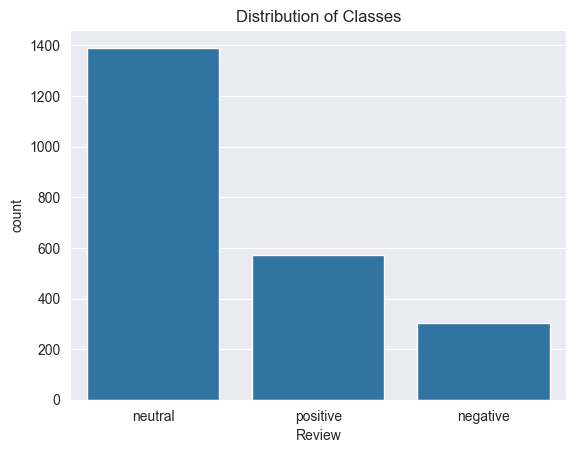

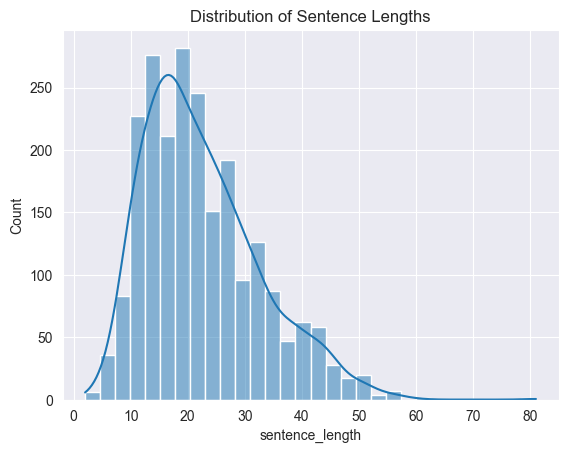

In [4]:
print("Dataset size:", df.shape)
print("Count of each label:\n", df['Review'].value_counts())

df['sentence_length'] = df['Sentence'].apply(lambda x: len(word_tokenize(x)))
print("Summary statistics for sentence lengths:\n", df['sentence_length'].describe())

sns.countplot(x='Review', data=df)
plt.title('Distribution of Classes')
plt.show()

sns.histplot(df['sentence_length'], bins=30, kde=True)
plt.title('Distribution of Sentence Lengths')
plt.show()

In [5]:
# Defining a function to clean the text data.
def clean_text(text):
    # Converting the text to lowercase.
    text = text.lower()
    
    # Removing any URLs from the text.
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    
    # Removing any non-word characters (everything except numbers and letters).
    text = re.sub(r'[^\w\s]', '', text)
    
    # Removing any numbers from the text.
    text = re.sub(r'\d+', '', text)
    
    # Returning the cleaned text.
    return text

# Applying the clean_text function to the 'Sentence' column of the DataFrame and store the result in a new column 'Cleaned_Sentence'.
df['Cleaned_Sentence'] = df['Sentence'].apply(clean_text)

In [6]:
print("Dataset size:", df.shape)
print("Count of each label:\n", df['Review'].value_counts())

Dataset size: (2264, 4)
Count of each label:
 Review
neutral     1391
positive     570
negative     303
Name: count, dtype: int64


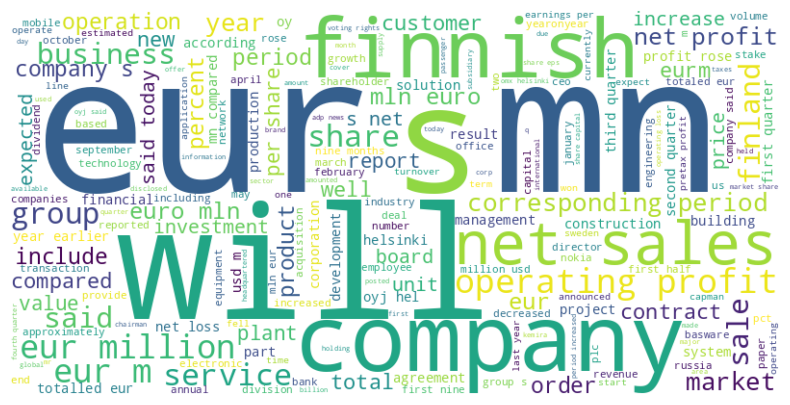

In [7]:
all_text = ' '.join(df['Cleaned_Sentence'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [8]:
# Splitting the dataset into training and testing sets.
# The 'Cleaned_Sentence' column is used as the feature (input), and the 'Review' column is used as the label (output).
# The test size is set to 20% of the total dataset, and a random state is set for reproducibility of results.
train_sentences, test_sentences, train_labels, test_labels = train_test_split(
    df['Cleaned_Sentence'].values, df['Review'].values, test_size=0.2, random_state=18)

In [9]:
# Setting the maximum number of words to be used in the tokenizer (based on word frequency). Here, it's set to 20000.
max_num_words = 20000

# Setting the maximum length for each sequence. Any sequence longer than this will be truncated and any sequence shorter than this will be padded. Here, it's set to 100.
max_seq_length = 100

# Initializing the Tokenizer with a specified maximum number of words to keep, based on word frequency.
tokenizer = Tokenizer(num_words=max_num_words)

# Fitting the tokenizer on the training sentences. This updates the internal vocabulary based on the list of texts.
tokenizer.fit_on_texts(train_sentences)

# Transforming each training sentence into a sequence of integers. Each integer corresponds to a token (word) in the dictionary of the tokenizer.
train_sequences = tokenizer.texts_to_sequences(train_sentences)

# Transforming each testing sentence into a sequence of integers, similar to the training sentences.
test_sequences = tokenizer.texts_to_sequences(test_sentences)

# Padding the training sequences to ensure that all sequences in a list have the same length. Sequences that are shorter than 'max_seq_length' are padded with zeros at the end.
train_padded = pad_sequences(train_sequences, maxlen=max_seq_length, padding='post')

# Padding the testing sequences in the same way as the training sequences.
test_padded = pad_sequences(test_sequences, maxlen=max_seq_length, padding='post')

In [10]:
# Creating a dictionary to map the labels to integers. Here, 'neutral' is mapped to 2, 'positive' to 0, and 'negative' to 1.
label_map = {"neutral": 2, "positive": 0, "negative": 1}

# Converting the 'train_labels' to integers using the 'label_map'. The result is a numpy array of integers.
train_labels_int = np.array([label_map[label] for label in train_labels])

# Converting the 'test_labels' to integers in the same way as 'train_labels'.
test_labels_int = np.array([label_map[label] for label in test_labels])

In [11]:
# Initializing the SMOTE (Synthetic Minority Over-sampling Technique) with 'minority' as the sampling strategy to resample the minority class. Set a random state for reproducibility of results.
smote = SMOTE(sampling_strategy='minority', random_state=18)

# Fitting the SMOTE on the training data and create a resampled version of the dataset. This will generate synthetic samples of the minority class.
train_padded_res, train_labels_res = smote.fit_resample(train_padded, train_labels_int)

In [12]:
# Converting the 'train_labels_res' to one-hot encoded vectors using the 'to_categorical' function. The number of classes is set to 3 (neutral, positive, negative).
train_labels_cat = to_categorical(train_labels_res, num_classes=3)

# Converting the 'test_labels_int' to one-hot encoded vectors in the same way as 'train_labels_res'.
test_labels_cat = to_categorical(test_labels_int, num_classes=3)

In [13]:
# Computing the class weights using the 'balanced' method, which adjusts weights inversely proportional to class frequencies in the input data.
# The unique classes and their corresponding labels are determined from 'train_labels_res'.
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels_res), y=train_labels_res)

# Converting the computed class weights into a dictionary where the keys are the class indices and the values are the corresponding weights.
class_weights = dict(enumerate(class_weights))

In [14]:
# A function named 'scheduler' that takes in two parameters: 'epoch' and 'lr' (learning rate).
# This function is used to adjust the learning rate during the training process.
# If the epoch number is less than 10, the function returns the current learning rate.
# If the epoch number is 10 or more, the function reduces the learning rate by multiplying it with the exponential of -0.1.
# This results in a gradual decrease in the learning rate as the number of epochs increases, which can help improve the model's performance.
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [15]:
# Initializing a Sequential model. This is a linear stack of layers that you can add to in a sequential manner.
model = Sequential()

# Adding an Embedding layer to the model. This layer turns positive integers (indexes) into dense vectors of fixed size.
# The input dimension is the size of the vocabulary (max_num_words), the output dimension is the size of the dense vector (128), and the input length is the length of input sequences (max_seq_length).
model.add(Embedding(input_dim=max_num_words, output_dim=128, input_length=max_seq_length))

# Adding a SpatialDropout1D layer to the model. This version of Dropout drops entire 1D feature maps instead of individual elements. The rate of dropout is set to 0.4.
model.add(SpatialDropout1D(0.4))

# Adding a Bidirectional LSTM layer to the model. This layer allows the LSTM to learn from both past (backwards) and future (forwards) data. The number of LSTM units is set to 128.
# The 'return_sequences' parameter is set to True to return the full sequence as output. The kernel regularizer forces the weights to be small, and the dropout rate is set to 0.3.
model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01), dropout=0.3)))

# Adding a BatchNormalization layer to the model. This layer normalizes the activations of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
model.add(BatchNormalization())

# Adding another Bidirectional LSTM layer to the model, similar to the previous one but with 64 LSTM units and 'return_sequences' set to False to return only the last output.
model.add(Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01), dropout=0.3)))

# Adding another BatchNormalization layer to the model.
model.add(BatchNormalization())

# Adding a Dense layer to the model. This layer is a regular densely-connected NN layer with 64 units and 'relu' activation function. The kernel regularizer is used to apply penalties on layer parameters during optimization.
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))

# Adding a Dropout layer to the model. This layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. The rate of dropout is set to 0.5.
model.add(Dropout(0.5))

# Adding a final Dense layer with 3 units (for the 3 classes: neutral, positive, negative) and 'softmax' activation function which makes it suitable for multi-class classification.
model.add(Dense(3, activation='softmax'))

In [16]:
# Initializing the Adam optimizer with a learning rate of 0.0001. Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent to update network weights iteratively based on the training data.
optimizer = Adam(learning_rate=1e-4)

# Compiling the model with the specified optimizer, loss function, and metrics.
# The loss function is set to 'categorical_crossentropy', which is suitable for multi-class classification problems.
# The metric used to evaluate the model is 'accuracy', which calculates how often predictions equal labels.
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Initializing the EarlyStopping callback. This stops training when a monitored quantity ('val_loss' in this case) has stopped improving.
# 'patience' is the number of epochs with no improvement after which training will be stopped. Here, it's set to 10.
# 'restore_best_weights' is set to True, meaning the model weights from the epoch with the best value of the monitored quantity will be restored.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Initializing the ReduceLROnPlateau callback. This reduces the learning rate when a metric ('val_loss' in this case) has stopped improving.
# The factor by which the learning rate will be reduced is 0.5. The 'patience' is set to 5, meaning the number of epochs with no improvement after which learning rate will be reduced.
# 'min_lr' is the lower bound on the learning rate. Here, it's set to 1e-6.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Initializing the LearningRateScheduler callback with the 'scheduler' function defined earlier.
# This callback is used for dynamic adjustment of the learning rate during the training process.
lr_scheduler = LearningRateScheduler(scheduler)

In [18]:
# Starting training the model using the 'fit' method.
# 'train_padded_res' and 'train_labels_cat' are the training data and corresponding labels respectively.
# The validation data and corresponding labels are 'test_padded' and 'test_labels_cat' respectively.
# The model is trained for 50 epochs, where an epoch is one complete pass through the entire training dataset.
# The batch size is set to 64, which is the number of samples per gradient update.
# 'class_weights' is used to provide a weight for each class that can be used to balance the dataset.
# The 'callbacks' parameter is a list of callbacks to apply during training. Here, it includes 'early_stopping' (to stop training when a monitored quantity has stopped improving), 'reduce_lr' (to reduce learning rate when a metric has stopped improving), and 'lr_scheduler' (for dynamic adjustment of the learning rate).
history = model.fit(
    train_padded_res, train_labels_cat,
    validation_data=(test_padded, test_labels_cat),
    epochs=50,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr, lr_scheduler]
)

Epoch 1/50
42/42 [==============================] - 15s 115ms/step - loss: 11.3018 - accuracy: 0.3405 - val_loss: 10.6032 - val_accuracy: 0.2494 - lr: 1.0000e-04
Epoch 2/50
42/42 [==============================] - 3s 70ms/step - loss: 10.6238 - accuracy: 0.3775 - val_loss: 10.0549 - val_accuracy: 0.2472 - lr: 1.0000e-04
Epoch 3/50
42/42 [==============================] - 3s 68ms/step - loss: 10.0348 - accuracy: 0.4151 - val_loss: 9.5467 - val_accuracy: 0.2362 - lr: 1.0000e-04
Epoch 4/50
42/42 [==============================] - 3s 69ms/step - loss: 9.4956 - accuracy: 0.4342 - val_loss: 9.0759 - val_accuracy: 0.2428 - lr: 1.0000e-04
Epoch 5/50
42/42 [==============================] - 3s 66ms/step - loss: 8.9704 - accuracy: 0.4763 - val_loss: 8.6211 - val_accuracy: 0.5121 - lr: 1.0000e-04
Epoch 6/50
42/42 [==============================] - 3s 66ms/step - loss: 8.4949 - accuracy: 0.5207 - val_loss: 8.1778 - val_accuracy: 0.7395 - lr: 1.0000e-04
Epoch 7/50
42/42 [===========================

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          2560000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 128)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         263168    
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 100, 256)         1024      
 ormalization)                                                   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                   

In [20]:
# Evaluating the model's performance on the test data. The 'evaluate' method returns the loss value and metrics values for the model.
# 'test_padded' and 'test_labels_cat' are the test data and corresponding labels respectively.
# The loss and accuracy are stored in the 'loss' and 'accuracy' variables respectively.
loss, accuracy = model.evaluate(test_padded, test_labels_cat)

print(f"Loss: {loss}")

print(f"Accuracy: {accuracy}")

15/15 [==============================] - 0s 21ms/step - loss: 4.4032 - accuracy: 0.8013
Loss: 4.403172969818115
Accuracy: 0.8013244867324829


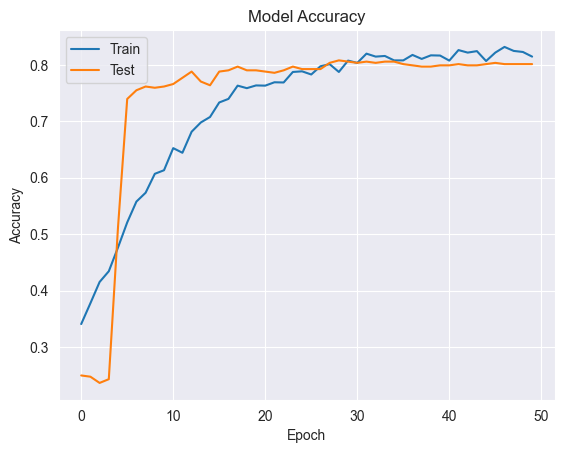

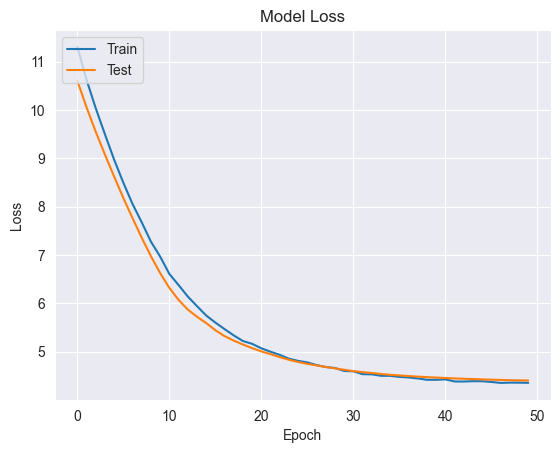

In [21]:
# plotting the training history
import matplotlib.pyplot as plt
# Plotting Accuracy and Loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

The provided graphs show the training and testing accuracy and loss of an RNN over 50 epochs. Initially, both accuracy and loss improve rapidly, indicating effective learning and generalization. As training continues, the accuracy stabilizes around 0.8 to 0.85, and the loss levels off around 5, with minimal overfitting. The close alignment of training and test metrics suggests good generalization.

15/15 [==============================] - 3s 30ms/step


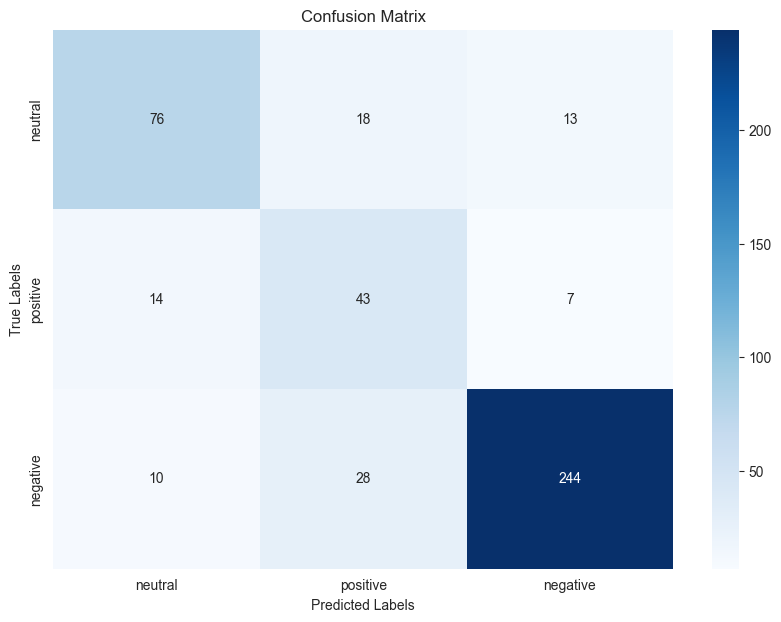

              precision    recall  f1-score   support

     neutral       0.76      0.71      0.73       107
    positive       0.48      0.67      0.56        64
    negative       0.92      0.87      0.89       282

    accuracy                           0.80       453
   macro avg       0.72      0.75      0.73       453
weighted avg       0.82      0.80      0.81       453


In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
pred_labels_cat = model.predict(test_padded)
pred_labels_int = np.argmax(pred_labels_cat, axis=1)

conf_matrix = confusion_matrix(test_labels_int, pred_labels_int)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(test_labels_int, pred_labels_int, target_names=label_map.keys())
print(class_report)

The confusion matrix shows that it performs best in predicting the negative class, correctly identifying 246 instances with minimal errors. The model has moderate accuracy for the neutral class, correctly predicting 78 instances but also misclassifying a significant number as positive or negative. The model struggles with the positive class, with only 37 correct predictions and a high number of misclassifications. These results suggest potential data imbalance favoring the negative class.